## UTAH FORGE PROJECT

Enable cutting-edge research and drilling and technology testing, as well as to allow scientists to identify a replicable, commercial pathway to EGS. In addition to the site itself, the FORGE effort will include a robust instrumentation, data collection, and data dissemination component to capture and share data and activities occurring at FORGE in real time. The innovative research, coupled with an equally-innovative collaboration and management platform, is truly a first of its kind endeavor. More details here https://utahforge.com/

#### The data used in this repository comes from the public data provided by Utah FORGE https://gdr.openei.org/submissions/1111

This Notebook is to inspect well data for Utah Forge Well 58-32

##### Some functions adapted from https://sainosmichelle.github.io/elements.html

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Read main logs in ft

In [18]:
main = lasio.read('./localUTAHFORGEDATA/58-32_main.las')
dfmain = main.df()
print(dfmain.index)

Float64Index([  10.5,   11.0,   11.5,   12.0,   12.5,   13.0,   13.5,   14.0,
                14.5,   15.0,
              ...
              7569.5, 7570.0, 7570.5, 7571.0, 7571.5, 7572.0, 7572.5, 7573.0,
              7573.5, 7574.0],
             dtype='float64', name='DEPT', length=15128)


In [19]:
dfmain.head(5)

,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,...,SPAR,STIT,TENS,TNPH,HTNP_SAN,ATCO10,ATCO20,ATCO30,ATCO60,ATCO90
DEPT,,,,,,,,,,,,,,,,,,,,,
10.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,0.0,940.9999,NaN,0.3744,840.4879,2040.422,35.6775,14.1442,50.6664
11.0,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,0.0,940.9999,NaN,0.3744,840.4879,2040.422,35.6775,14.1442,50.6664
11.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,0.0,940.9999,NaN,0.3744,840.4879,2040.422,35.6775,14.1442,50.6664
12.0,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,0.0,940.9999,NaN,0.3744,840.4879,2040.422,35.6775,14.1442,50.6664
12.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,0.0,940.9999,NaN,0.3744,840.4879,2040.422,35.6775,14.1442,50.6664


#### Read sonic logs in ft

In [20]:
sonic = lasio.read('./localUTAHFORGEDATA/58-32_sonic.las')
dfsonicall = sonic.df()
dfsonicall['VpVs']= ((1/dfsonicall['DTCO'])/(1/dfsonicall['DTSM']))
dfsonic = dfsonicall[['DT1R','DT2','DT2R','DT4P','DT4S','DTCO','DTRP','DTRS','DTSM','ITT','PR','SPHI','VpVs']]
print(dfsonic.index)

Float64Index([2150.5, 2151.0, 2151.5, 2152.0, 2152.5, 2153.0, 2153.5, 2154.0,
              2154.5, 2155.0,
              ...
              7564.5, 7565.0, 7565.5, 7566.0, 7566.5, 7567.0, 7567.5, 7568.0,
              7568.5, 7569.0],
             dtype='float64', name='DEPT', length=10838)


#### Merge main and sonic logs (not repeated curves) using pandas

In [21]:
all_logs = pd.concat([dfmain, dfsonic], axis=1, sort=False)
#all_logs.info()

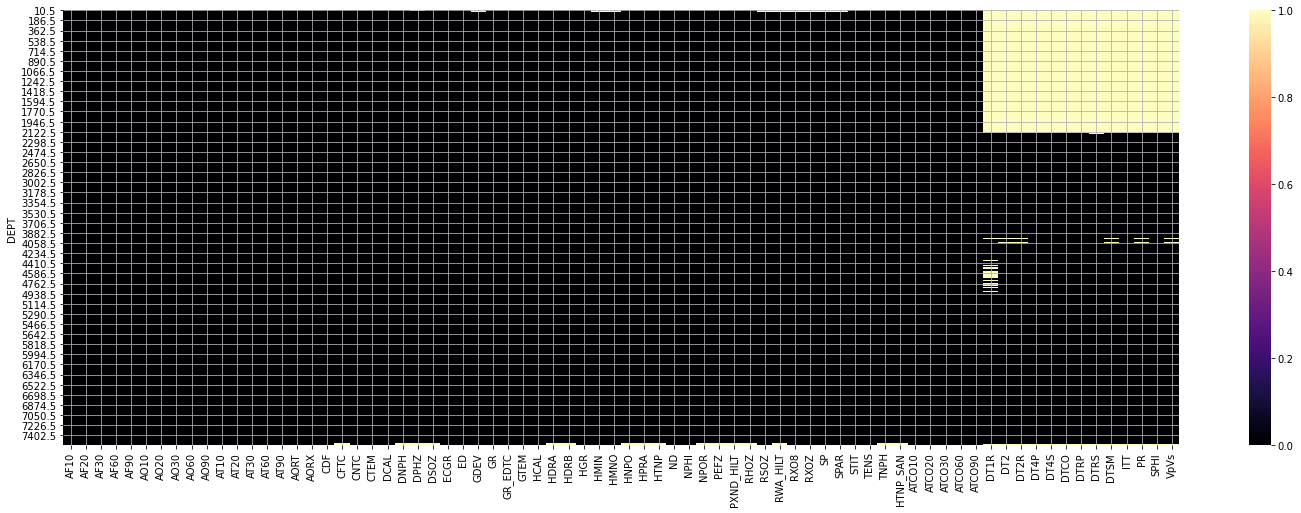

In [22]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(all_logs.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

#### Calculations based on publication "Well-log based prediction of thermal conductivity of sedimentary successions: a case study from the North German Basin. Fuchs, S., and Foster, A. Geophysical Journal International. 2014. 196, pg 291-311. doi: 10.1093/gji/ggt382

In [23]:
#calculate Vsh from GR formula Vsh=(subdata.GR_EDTC-grmin)/(grmax-grmin)
all_logs['Vsh'] = all_logs['GR'] - min(all_logs['GR'])/(max(all_logs['GR'])- min(all_logs['GR']))

#calculate NPHI matrix from NPHI porosity and DEN porosity neu_m=subdata.NPOR-subdata.DPHZ
all_logs['NPOR_m'] = (all_logs['NPOR']) - (all_logs['DPHZ'])   

#calculate eq10
#Matrix-TC equation derived from regression analysis for clastic rock types
all_logs['eq10'] = (5.281-(2.961*all_logs['NPOR_m'])-(2.797*all_logs['Vsh']))/-272.15

#calculate eq11
#Bulk-TC equation derived from regression analysis for subsurface data
all_logs['eq11'] = (4.75-(4.19*all_logs['NPOR'])-(1.81*all_logs['Vsh']))/-272.15

#all_logs.info()

In [24]:
#read discrete data - conversion to ft - depth equal to lower depth interval 
tops = pd.read_csv('s3://geotermaldata/S3UTAHFORGEDATA/58-32_tops.csv')

#Thermal Conductivity 
TC_coredata = pd.read_csv ('s3://geotermaldata/S3UTAHFORGEDATA/58-32_thermal_conductivity_data.csv') 
TC_coredata['Depth'] = (3.28084*TC_coredata['Lower Depth Interval (m)'])
TC_coredata['Matrix_TC']=TC_coredata['matrix thermal conductivity (W/m deg C)']
TC_coredata.set_index('Depth', inplace=True)

#XRD lab data
XRD_coredata = pd.read_csv ('s3://geotermaldata/S3UTAHFORGEDATA/58-32_xray_diffraction_data.csv') 
XRD_coredata = XRD_coredata.replace('tr',0)
XRD_coredata['Depth'] = (3.28084*XRD_coredata['Lower Depth Range (m)'])
XRD_coredata.set_index('Depth', inplace=True)

#TC_coredata.tail(15)

In [25]:
XRD_coredata.head()

,Lower Depth Range (m),Upper Depth Range (m),Smectite,Illite,Chlorite,Interlayered\nChlorite-Smectite,% chlorite in C/S,Kaolinite,Biotite,Hornblende,...,Apatite,Plagioclase,K-feldspar,Quartz,Epidote,Calcite,Dolomite,Siderite,Anhydrite,Hematite
Depth,,,,,,,,,,,,,,,,,,,,,
100.065620,30.5,33.5,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,40,44,17,NaN,NaN,NaN,NaN,NaN,NaN
200.131240,61.0,64.0,0.0,4,NaN,NaN,NaN,NaN,0,NaN,...,NaN,42,33,20,NaN,NaN,NaN,NaN,NaN,0
299.868776,91.4,94.5,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,39,34,26,NaN,2,NaN,NaN,NaN,NaN
399.934396,121.9,125.0,0.0,4,NaN,NaN,NaN,NaN,1,NaN,...,NaN,35,39,20,NaN,NaN,NaN,NaN,NaN,0
500.000016,152.4,155.4,0.0,4,NaN,NaN,NaN,NaN,0,NaN,...,NaN,35,39,21,NaN,NaN,NaN,NaN,NaN,0


#### Inspect Data

In [26]:
#basic plot to inspect data 
def make_layout_tc (log_df, XRD, TC):
    
    import numpy as np
    import pandas as pd
    import matplotlib
    import matplotlib.pyplot as plt
  
    fig, axs = plt.subplots(nrows=1, ncols=6, sharey=True, squeeze=True, figsize=(15, 15), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (ft)')
    axs[0].invert_yaxis()
    axs[0].get_xaxis().set_visible(False)
    
    # First track GR/SP/CALI logs to display
    ax1 = axs[0].twiny()  
    ax1.plot(log_df.GR, log_df.index, '-', color='#2ea869', linewidth=0.5)
    ax1.set_xlim(0,450) 
    ax1.set_xlabel('GR (API)', color='#2ea869')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15)) 
    
    ax2 = axs[0].twiny() 
    ax2.plot(log_df.SP, log_df.index, '-', color='#0a0a0a', linewidth=0.7)
    ax2.set_xlim(-200,200) 
    ax2.set_xlabel('SP(mV)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))    
      
    ax3 = axs[0].twiny() 
    ax3.plot(log_df.DCAL, log_df.index, '--', color='#9da4a1', linewidth=0.5)
    ax3.set_xlim(-5,15) 
    ax3.set_xlabel('DCAL (in)', color='#9da4a1')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[0].get_xaxis().set_visible(False)
    
    # Second track RHOB/NPHI/PEF logs to display
    ax1 = axs[1].twiny()  
    ax1.plot(log_df.RHOZ, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax1.set_xlim(1.5,3.0) 
    ax1.set_xlabel('RHOB (g/cm3)', color='#ea0606')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[1].twiny()  
    ax2.plot(log_df.NPHI, log_df.index, '-', color='#1577e0', linewidth=0.5)
    ax2.set_xlim(1,0) 
    ax2.set_xlabel('NPHI (v/v)', color='#1577e0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[1].twiny()  
    ax3.plot(log_df.PEFZ, log_df.index, '-', color='#1acb20', linewidth=0.5)
    ax3.set_xlim(0,15) 
    ax3.set_xlabel('PEFZ (b/e)', color='#1acb20')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[1].get_xaxis().set_visible(False)
    
    # Third track Resistivities
    ax1 = axs[2].twiny()  
    ax1.plot(log_df.AT10, log_df.index, '-', color='#d6dbd7', linewidth=0.5)
    ax1.set_xlim(0.2,20000)  
    ax1.set_xlabel('AT10 (ohm.m)', color='#d6dbd7')
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))
    
    ax2 = axs[2].twiny()  
    ax2.plot(log_df.AT30, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(0.2,20000)  
    ax2.set_xlabel('AT30 (ohm.m)', color='#0a0a0a')
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[2].twiny()  
    ax3.plot(log_df.AT90, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax3.set_xlim(0.2,20000)  
    ax3.set_xlabel('AT90 (ohm.m)', color='#ea0606')
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[2].get_xaxis().set_visible(False)

   # Forth track Sonic
    ax1 = axs[3].twiny()  
    ax1.plot(log_df.DTSM, log_df.index, '-', color='#9da4a1', linewidth=0.5)
    ax1.set_xlim(200,40) 
    ax1.set_xlabel('DTS (us/ft)', color='#9da4a1')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))
    
    ax2 = axs[3].twiny()  
    ax2.plot(log_df.DTCO, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(200,40) 
    ax2.set_xlabel('DTC (us/ft)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[3].twiny()  
    ax3.plot(log_df.VpVs, log_df.index, '-', color='#e1093f', linewidth=0.5)
    ax3.set_xlim(1,3) 
    ax3.set_xlabel('VpVs (unitless)', color='#e1093f')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[3].get_xaxis().set_visible(False)


  # Fifth track XRD to display
    ax1 = axs[4].twiny()  
    ax1.plot(XRD.Quartz, XRD.index, 'o', color='#eac406')
    ax1.set_xlim(0,100) 
    ax1.set_xlabel('Quartz %', color='#eac406')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[4].twiny()  
    ax2.plot(XRD['K-feldspar'], XRD.index, 'o', color='#05a9f0')
    ax2.set_xlim(0,100) 
    ax2.set_xlabel('K-feldspar %', color='#05a9f0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[4].twiny()  
    ax3.plot(XRD['Illite'], XRD.index, 'o', color='#94898c')
    ax3.set_xlim(0,100) 
    ax3.set_xlabel('Illite %', color='#94898c')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[4].get_xaxis().set_visible(False)


    # Sixth track Temp/TC to display
    ax1 = axs[5].twiny()  
    ax1.plot(TC.Matrix_TC, TC.index, 'o', color='#6e787c')
    ax1.set_xlim(0,5) 
    ax1.set_xlabel('Matrix TC Measured W/mC', color='#6e787c')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.075))

    ax2 = axs[5].twiny()  
    ax2.plot(log_df.CTEM, log_df.index, '-', color='#ed8712')
    ax2.set_xlim(0,300) 
    ax2.set_xlabel('Temp degF', color='#ed8712')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.0))
    ax2.grid(True)
    axs[5].get_xaxis().set_visible(False)
         
    fig.suptitle('Well Data for UTAH FORGE 58-32',weight='bold', fontsize=20, y=0.9);
    plt.show()

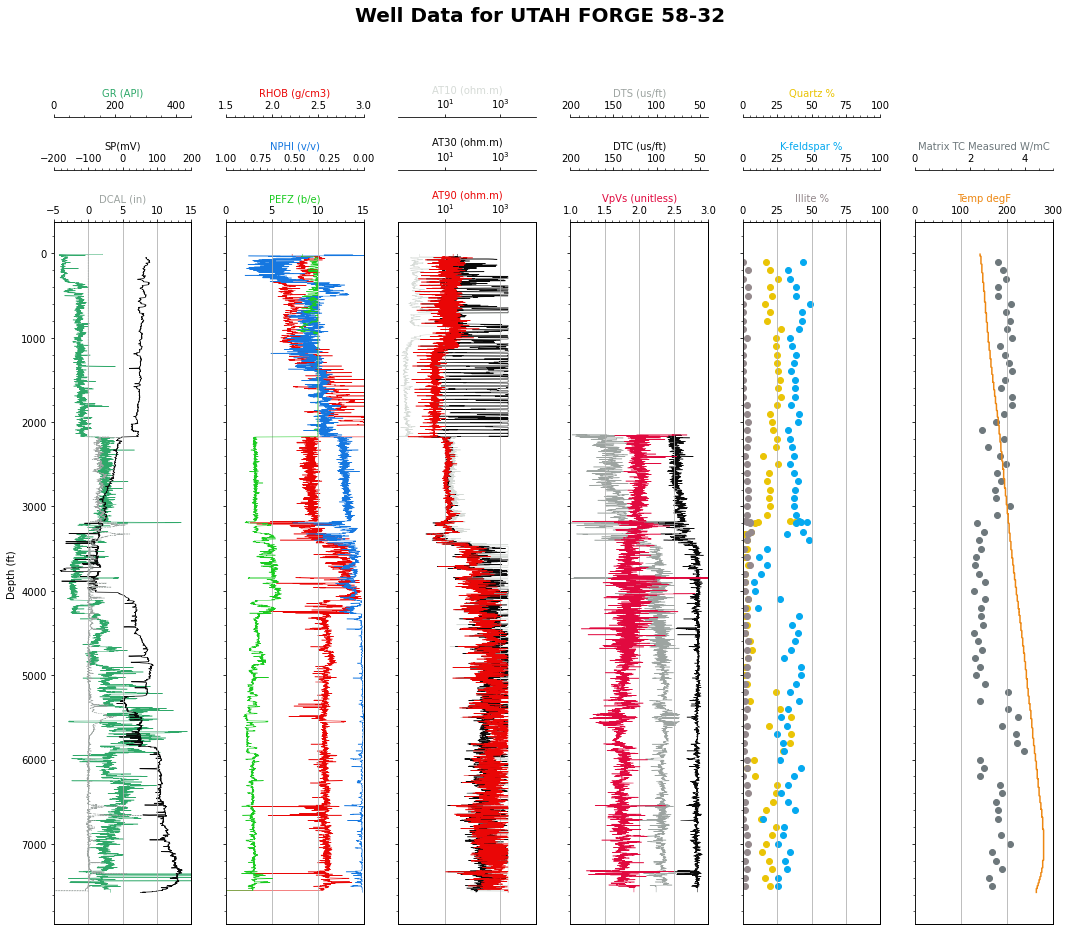

In [27]:
make_layout_tc (all_logs, XRD_coredata, TC_coredata)

In [ ]:
all_logs.to_csv('./localUTAHFORGEDATA/all_logs.csv')